# Réalisez une application de recommandation de contenu
## Filtrage basé sur le contenu

Comme pour le filtrage collaboratif, il existe plusieurs méthodes pour faire de la recommendation basé sur le contenu.  
Réseau de graph, renforcement, auto encodeur, ... Pas mal d'exemple sont disponible depuis la librairies "[recommenders](https://github.com/recommenders-team/recommenders/tree/main/examples/02_model_content_based_filtering)" mais requiert un accès plus ouvert aux données. Ici on a que l'article embedding et pas le contenu. 
Du coup j'ai choisi de le faire sur un modèle deep learning simple de deux couches d'apprentissage avec dropout de 20% par couche.

### Importation des librairies

In [1]:
##### Imports and Dataset Loading #####
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
from tqdm import tqdm
from tensorflow.keras import layers, models
from keras.metrics import RootMeanSquaredError
import pickle
import os
import tensorflow as tf

from helpers import load_dataset, preprocessing_articles, preprocessing_clicks, prepare_data


#### Récupération des datasets & préparation des données

In [32]:
# Load datasets
df_articles, df_clicks, article_embeddings = load_dataset()

Je fait un PCA ici qui explique variance. Je réduit le nombre de dimensions qui permet de réduire la taille du modèle et augmente ainsi son temps d'entrainement et d'inférence.

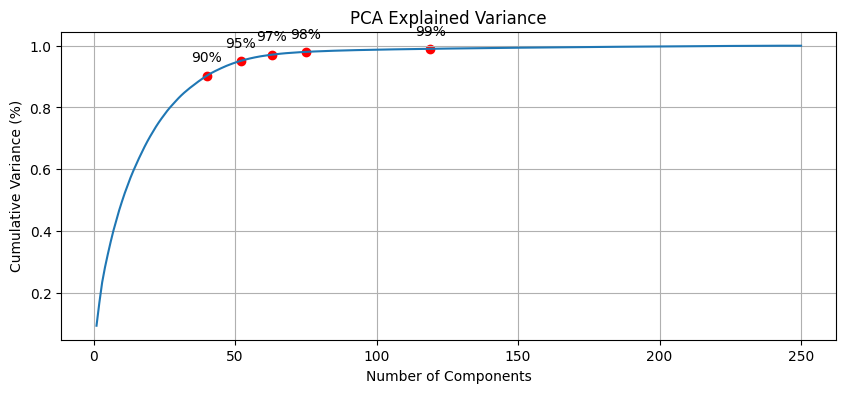

In [2]:
# Fit PCA
pca = PCA()
pca.fit(article_embeddings)

# Variance data
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
components = np.arange(len(cumulative_variance)) + 1

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(components, cumulative_variance, label='Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)')
plt.title('PCA Explained Variance')

# Annotate specific variance percentages
variance_thresholds = [0.9, 0.95, 0.97, 0.98, 0.99]
for threshold in variance_thresholds:
    component_number = np.where(cumulative_variance >= threshold)[0][0]
    plt.scatter(component_number + 1, cumulative_variance[component_number], color='red')
    plt.annotate(f"{int(threshold * 100)}%", 
                 (component_number + 1, cumulative_variance[component_number]),
                 textcoords="offset points", 
                 xytext=(0, 10), ha='center')

plt.grid(True)
plt.show()

# PCA with 98% variance
pca = PCA(n_components=0.98)
reduced_embeddings = pca.fit_transform(article_embeddings)
article_embeddings = reduced_embeddings


In [3]:
##### Preprocessing #####
# Preprocess data
df_articles = preprocessing_articles(df_articles)
df_clicks = preprocessing_clicks(df_clicks)
articles_embed_df = pd.DataFrame(article_embeddings)

# Filter articles clicked
articles_clicked = df_clicks.click_article_id.value_counts().index
df_articles = df_articles.loc[articles_clicked]
articles_embed_df = articles_embed_df.loc[articles_clicked]

# Print shapes
print("df_articles shape:", df_articles.shape)
print("article_embeddings shape:", articles_embed_df.shape)

df_articles shape: (46033, 5)
article_embeddings shape: (46033, 75)


J'entraine mon modèle sur un million de click au lieu des 2.8 millions car le modèle était assez lourd et les résultats sont satisfaisant.

In [4]:
# df_articles = df_articles.sample(n=5000)
df_clicks = df_clicks.sample(n=1000000)

In [5]:
# Train-Test Split by session id
def train_test_split_sessions(clicks_df, test_size=0.05, val_size=0.1, random_state=42):
    session_ids = clicks_df['session_id'].unique()
    train_sessions, val_sessions = train_test_split(session_ids, test_size=val_size, random_state=random_state)
    train_sessions, test_sessions = train_test_split(train_sessions, test_size=test_size, random_state=random_state)
    train_df = clicks_df[clicks_df['session_id'].isin(train_sessions)]
    val_df = clicks_df[clicks_df['session_id'].isin(val_sessions)]
    test_df = clicks_df[clicks_df['session_id'].isin(test_sessions)]
    return train_df, val_df, test_df

train_clicks_df, val_clicks_df, test_clicks_df = train_test_split_sessions(df_clicks)

print(f"Training clicks shape: {train_clicks_df.shape}")
print(f"Validation clicks shape: {val_clicks_df.shape}")
print(f"Testing clicks shape: {test_clicks_df.shape}")

Training clicks shape: (854807, 14)
Validation clicks shape: (100093, 14)
Testing clicks shape: (45100, 14)


Je créer un profil utilisateur pour préparer mes données d'entrainement.  
La moyenne de chaque article embedding visité par utilisateur.

L'utilisateur à visité l'article 1,2,3, je fais la moyenne de leur embeddings qui sera utilisé lors de l'entrainement.

In [6]:
# User Profile Creation
def create_user_profiles(clicks_df, article_embeddings_df):
    user_profiles = clicks_df.groupby('user_id')['click_article_id'].apply(list).reset_index()
    embeddings_dict = article_embeddings_df.T.to_dict('list')
    
    user_profiles['user_embedding'] = user_profiles['click_article_id'].progress_apply(
        lambda x: np.mean([embeddings_dict[article] for article in x if article in embeddings_dict], axis=0)
    )
    
    return user_profiles

tqdm.pandas()
user_profiles_train = create_user_profiles(train_clicks_df, articles_embed_df)
user_profiles_val = create_user_profiles(val_clicks_df, articles_embed_df)
user_profiles_test = create_user_profiles(test_clicks_df, articles_embed_df)
user_profiles_all = create_user_profiles(df_clicks, articles_embed_df)

100%|██████████| 257609/257609 [00:03<00:00, 76074.29it/s] 


In [33]:
user_profiles_all.head()

,user_id,click_article_id,user_embedding
0,0,"[313996, 87205, 160158, 233470, 68866]","[2.1062619507312776, -0.1438710629940033, -0.9..."
1,1,"[36162, 234481, 327984, 59758, 156723, 285719]","[1.8992497796813648, -0.5945192440412939, -0.5..."
2,2,"[119592, 30760, 209122]","[-0.24739154179890951, -2.3055147329966226, -0..."
3,3,"[236671, 236065, 284985, 235665]","[1.6503384597599506, -1.6864146292209625, -1.5..."
4,4,"[195887, 271261]","[-0.22136902809143066, -2.069472700357437, -0...."


Je créer un réseau de neurones de 6 couches.  
2 Couches d'apprentissage (de 128 puis 64 unités), avec un dropout de 20% par couche d'apprentissage.

In [7]:
def create_content_based_model(input_dim):
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

Je prépare l'input du modèle en combinant l'embedding profile utilisateur (moyenne des articles) et de chaque article lu par l'utilisateur.  
J'y ajoute des données négative pour améliorer l'entrainement. Par example, si l'utilisateur à cliqué sur 5 articles, alors j'ajouterai 5 articles négatif (non cliqué).

J'en profite pour sauvegardé le résultat dans un fichier et de le réutiliser au besoin pour ne pas avoir à attendre de nouveau

In [8]:
# Data Preparation
def prepare_data(user_profiles_df, articles_df, articles_embed_df):
    X, y = [], []
    embeddings_dict = articles_embed_df.T.to_dict('list')

    for _, user in tqdm(user_profiles_df.iterrows(), total=len(user_profiles_df)):
        user_embedding = user['user_embedding']
        clicked_articles = user['click_article_id']
        
        for article_id in clicked_articles:
            if article_id in embeddings_dict:
                article_embedding = embeddings_dict[article_id]
                combined_features = np.concatenate((user_embedding, article_embedding))
                X.append(combined_features)
                y.append(1) # Positive sample
        
        # Add some negative samples for training
        negative_samples = articles_df[~articles_df['article_id'].isin(clicked_articles)]['article_id'].sample(n=len(clicked_articles))
        
        for article_id in negative_samples:
            if article_id in embeddings_dict:
                article_embedding = embeddings_dict[article_id]
                combined_features = np.concatenate((user_embedding, article_embedding))
                X.append(combined_features)
                y.append(0) # Negative sample
                
    return np.array(X), np.array(y)

pickle_file = 'output/Xy_train_val.pkl'
if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as f:
        data = pickle.load(f)
        X_train, y_train, X_val, y_val = data['X_train'], data['y_train'], data['X_val'], data['y_val']
else:
    X_train, y_train = prepare_data(user_profiles_train, df_articles, articles_embed_df)
    X_val, y_val = prepare_data(user_profiles_val, df_articles, articles_embed_df)
    
    with open(pickle_file, 'wb') as f:
        pickle.dump({'X_train': X_train, 'y_train': y_train, 'X_val': X_val, 'y_val': y_val}, f)

100%|██████████| 55498/55498 [01:15<00:00, 733.37it/s]


Et c'est parti j'entraîne le modèle

In [38]:
##### Model Training #####
input_dim = X_train.shape[1]
content_based_model = create_content_based_model(input_dim)

content_based_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(),
    loss='binary_crossentropy',
    metrics=[RootMeanSquaredError()])

# Train the model
history = content_based_model.fit(
    X_train, 
    y_train, 
    epochs=10, 
    batch_size=32,
    validation_data=(X_val, y_val),
)

Epoch 1/10
53426/53426 [==============================] - 30s 559us/step - loss: 0.1756 - root_mean_squared_error: 0.2280 - val_loss: 0.0443 - val_root_mean_squared_error: 0.1082
Epoch 2/10
53426/53426 [==============================] - 28s 530us/step - loss: 0.1357 - root_mean_squared_error: 0.1986 - val_loss: 0.0396 - val_root_mean_squared_error: 0.1023
Epoch 3/10
53426/53426 [==============================] - 29s 546us/step - loss: 0.1265 - root_mean_squared_error: 0.1913 - val_loss: 0.0351 - val_root_mean_squared_error: 0.0966
Epoch 4/10
53426/53426 [==============================] - 32s 604us/step - loss: 0.1210 - root_mean_squared_error: 0.1868 - val_loss: 0.0341 - val_root_mean_squared_error: 0.0953
Epoch 5/10
53426/53426 [==============================] - 30s 556us/step - loss: 0.1176 - root_mean_squared_error: 0.1840 - val_loss: 0.0329 - val_root_mean_squared_error: 0.0934
Epoch 6/10
53426/53426 [==============================] - 29s 534us/step - loss: 0.1151 - root_mean_squar

Je sauvegarde tout ce qui me sera utile pour l'inférence plus tard.

In [39]:
##### Save Model and Data #####
content_based_model.save('./output/content_based_model.h5')

user_profiles_test.to_pickle("./output/user_profiles_test.pkl")
with open('./output/embeddings_dict.pkl', 'wb') as f:
    pickle.dump(user_profiles_test.to_dict(), f)

user_profiles_all.to_pickle("./output/user_profiles_all.pkl")
df_articles.to_pickle("./output/df_articles.pkl")
articles_embed_df.to_pickle("./output/articles_embed_df.pkl")

with open('./output/articles_metadata.json', 'w') as f:
    json.dump(df_articles[["article_id", "category_id"]].to_dict(), f)

/Users/m/dev/6be709c0/oc-ai-engineer/OC/P10/venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
df_articles[df_articles["article_id"] == 337438]

,article_id,category_id,publisher_id,words_count,created_at_dt
click_article_id,,,,,
337438,337438,437,0,178,2017-10-13 08:13:49


In [18]:
def compute_ndcg_at_k(user_profile, articles_df, articles_embed_df, model, k=5):
    user_embedding = user_profile['user_embedding']
    all_articles = articles_df['article_id'].values
    clicked_articles = user_profile['click_article_id']
    candidate_articles = all_articles.copy()

    embeddings_dict = articles_embed_df.T.to_dict('list')
    X_candidate = [
        np.concatenate((user_embedding, embeddings_dict[article_id]))
        for article_id in candidate_articles if article_id in embeddings_dict
    ]
    
    scores = model.predict(np.array(X_candidate), verbose=0)
    ranked_articles_with_scores = sorted(zip(scores, candidate_articles), reverse=True)
    top_k_recommendations_with_scores = ranked_articles_with_scores[:k]
    top_k_recommendations = [article for _, article in top_k_recommendations_with_scores]
    articles_id_by_rank = [article for _, article in ranked_articles_with_scores]
    top_k_scores = [score for score, _ in top_k_recommendations_with_scores]
    
    relevance = [1 if article in clicked_articles else 0 for article in top_k_recommendations]

    ndcg_value = ndcg_score([relevance], [list(range(len(relevance)))], k=k)
    
    clicked_articles_indices = [
        articles_id_by_rank.index(article) if article in articles_id_by_rank else -1
        for article in clicked_articles
    ]
    
    return ndcg_value, top_k_recommendations, list(zip(top_k_recommendations, top_k_scores)), clicked_articles_indices, articles_id_by_rank

In [19]:
def compute_mrr(user_profile, article_ids):
    clicked_articles = user_profile['click_article_id']
    for rank, article_id in enumerate(article_ids):
        if article_id in clicked_articles:
            return 1 / (rank + 1)
    return 0  # No relevant article found in top-k

Je check un user et regarde précisement le calcul du score.

In [41]:
user_profile = user_profiles_test.iloc[0]
print(f"The user clicked on the articles {user_profile['click_article_id']}")
ndcg, top_k_recommendations, score_per_article, clicked_articles_indices, articles_id_by_rank = compute_ndcg_at_k(user_profile, df_articles, articles_embed_df, content_based_model, k=5)
mrr = compute_mrr(user_profile, articles_id_by_rank)

gain_values = [1 for _ in clicked_articles_indices]
discounted_gains = [gain / np.log2(rank + 2) for gain, rank in zip(gain_values, clicked_articles_indices)]
ideal_dcg = sum(gain / np.log2(i + 2) for i, gain in enumerate(sorted(gain_values, reverse=True)[:5]))

print(f"### User NDCG@5 Score: {ndcg:.4f}")
# Explanation for NDCG@5
print(f"\n- NDCG@5 is computed by measuring the gain of each clicked article and discounting the gain logarithmically by its rank position")
print(f"- Clicked articles in the recommended list are: \n{user_profile['click_article_id']}")
print(f"- Their ranks in the recommended list are: \n{sorted(clicked_articles_indices)}")
print(f"- NDCG@5 accumulates the gains for the top 5 recommendations, adjusting for their rank position:")
print(f"  - The computation is: sum((gain/log2(rank + 2)) for each clicked article in top 5) / ideal DCG ({ideal_dcg:.4f})")
print(f"  - NDCG@5 score: {ndcg:.4f}")

print(f"\n### User MRR Score: {mrr:.4f}")
print(f"\n- Because the articles clicked are \n{user_profile['click_article_id']}\nare in the following rank\n{sorted(clicked_articles_indices)}")
print(f"\n- So it divide 1 by (the rank of the first one + 1): 1 / ('{sorted(clicked_articles_indices)[0]} + 1)' = {mrr:.4f}")

The user clicked on the articles [313504]
### User NDCG@5 Score: 0.3869

- NDCG@5 is computed by measuring the gain of each clicked article and discounting the gain logarithmically by its rank position
- Clicked articles in the recommended list are: 
[313504]
- Their ranks in the recommended list are: 
[0]
- NDCG@5 accumulates the gains for the top 5 recommendations, adjusting for their rank position:
  - The computation is: sum((gain/log2(rank + 2)) for each clicked article in top 5) / ideal DCG (1.0000)
  - NDCG@5 score: 0.3869

### User MRR Score: 1.0000

- Because the articles clicked are 
[313504]
are in the following rank
[0]

- So it divide 1 by (the rank of the first one + 1): 1 / ('0 + 1)' = 1.0000


Je check tous les users de user_profiles_test pour déterminer les scores du modèle

In [27]:
# Compute mean NDCG@5 and MRR for all user profiles in the test set
ndcg_scores = []
mrr_scores = []
for _, user_profile in tqdm(user_profiles_test.iterrows(), total=user_profiles_test.shape[0]):
# for _, user_profile in tqdm(user_profiles_test.iterrows(), total=user_profiles_test.shape[0]):
    ndcg, top_k_recommendations, score_per_article, clicked_articles_indices, articles_id_by_rank = compute_ndcg_at_k(user_profile, df_articles, articles_embed_df, content_based_model, k=5)
    mrr = compute_mrr(user_profile, articles_id_by_rank)
    
    ndcg_scores.append(ndcg)
    mrr_scores.append(mrr)

100%|██████████| 27618/27618 [13:44:23<00:00,  1.79s/it]  


In [29]:
mean_ndcg_score = np.mean(ndcg_scores)
mean_mrr_score = np.mean(mrr_scores)
# MRR SCORE IS INCORRECT, IT SHOULD DO IT BASED ON ALL ARTICLE, NOT the top recommended
print(f"NDCG@5 Score: {mean_ndcg_score:.4f}")
print(f"MRR Score: {mean_mrr_score:.4f}")

NDCG@5 Score: 0.4392
MRR Score: 0.9629
